# Estimating fate probabilities and driver genes

In this tutorial, you will learn how to...

- compute and visualize fate probabilities towards terminal states. 
- aggregate fate probabilities over groups of cells to uncover fate-biased populations.
- correlate fate probabilities with gene expression to detect putative driver genes of fate decisions. 

To demonstrate the appproach in this tutorial, we use a scRNA-seq dataset of pancreas development at embyonic day E15.5 <cite data-cite="bastidas-ponce:19"></cite>. We used this dataset in our [cellrank meets rna velocity](https://cellrank.readthedocs.io/en/stable/cellrank_meets_rna_velocity.html) and [initial & terminal states](https://cellrank.readthedocs.io/en/stable/initial_terminal_states.html) tutorials to compute a cell-cell transition matrix and infer terminal states, respectively; this tutorial builds on analysis presented there. 

<div class="alert alert-info">
Important

If you want to run this on your own data, you will need...

- a scRNA-seq dataset for which you computed a cell-cell transition matrix using any CellRank kernel. For each kernel, there exist individual tutorials that teach you how to use them. 

</div>

This tutorial notebook can be downloaded using the following [link](https://github.com/theislab/cellrank_notebooks/raw/master/tutorials/fate_probabilities.ipynb).

## Import packages & data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/theislab/cellrank@dev

In [3]:
import scvelo as scv
import scanpy as sc
import cellrank as cr

from scipy.stats import ttest_ind
import numpy as np

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

Global seed set to 0


In [4]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

Read AnnData object from disk (or download) and reconstruct a [VelocityKernel](https://cellrank.readthedocs.io/en/latest/api/_autosummary/kernels/cellrank.kernels.VelocityKernel.html#) from it. 

In [5]:
adata = sc.read('datasets/ML_2022-06-23_pancreas_with_transition_matrix.h5ad')

vk = cr.kernels.VelocityKernel.from_adata(adata, key='T_fwd')
vk

VelocityKernel[n=2531, model='deterministic', similarity='correlation', softmax_scale=3.797]

<div class="alert alert-info">
Important

The method `from_adata()` allows you to reconstruct a CellRank kernel from an [AnnData](https://anndata.readthedocs.io/en/latest/) object. When you use a kernel to compute a transition matrix, this matrix, as well as a few informations about the computation, are written to the underlying AnnData object. This makes it easy to write and read kernels from disk via the associated AnnData object. 

</div>

## Compute terminal states

We need to infer or assign terminal states before we can compute fate probabilities towards them. We will go over this quickly here, to learn more terminal state inference, see the [initial and terminal states](https://cellrank.readthedocs.io/en/stable/initial_terminal_states.html) tutorial. 

In [6]:
g = cr.estimators.GPCCA(vk)
print(g)

GPCCA[kernel=VelocityKernel[n=2531], initial_states=None, terminal_states=None]


Fit the estimator to obtain macrostates and declare terminal states. 

Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[11]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Computing `12` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:06)
Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


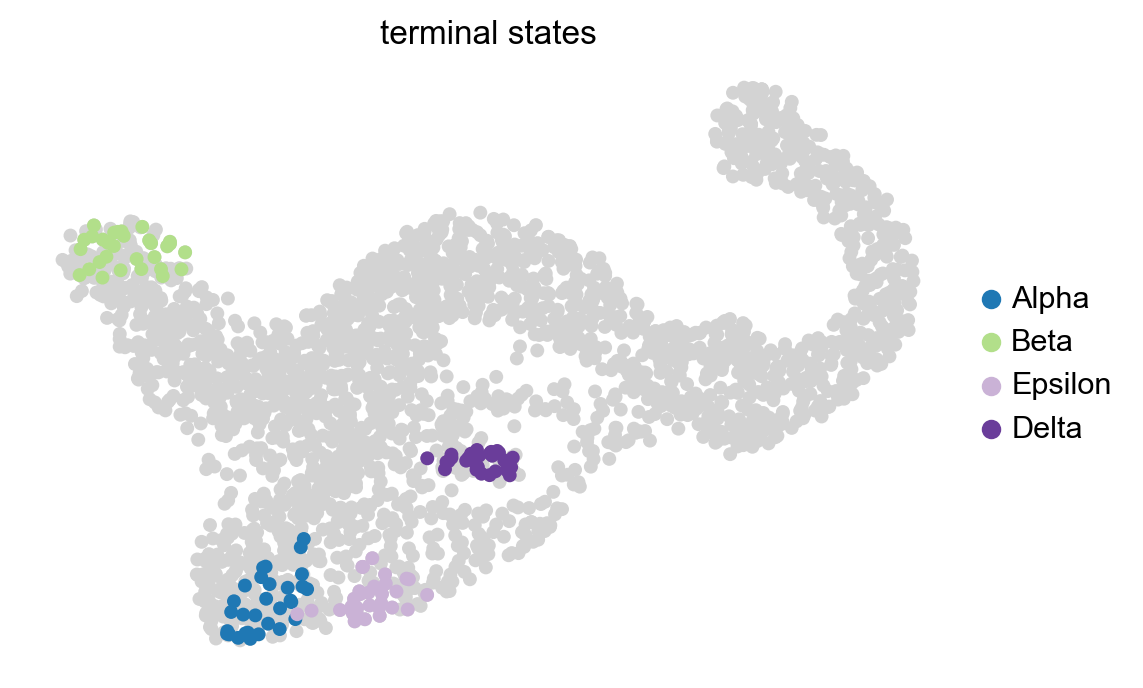

In [7]:
g.fit(cluster_key='clusters', n_states=12)

g.set_terminal_states(states=['Alpha', 'Beta', 'Epsilon', 'Delta'])
g.plot_macrostates(which='terminal', legend_loc='right', size=100)

## Infer fate probabilities

We compute fate probabilities by aggregating over all random walks that start in a given cell and end in some terminal population. There exists an analytical solution to this problem called [absorption probabilities](https://en.wikipedia.org/wiki/Absorbing_Markov_chain), their computation is 30x faster in CellRank 2 compared to version 1 and scales to millions of cells. 

Computing absorption probabilities


  0%|          | 0/4 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.absorption_probabilities`
    Finish (0:00:00)


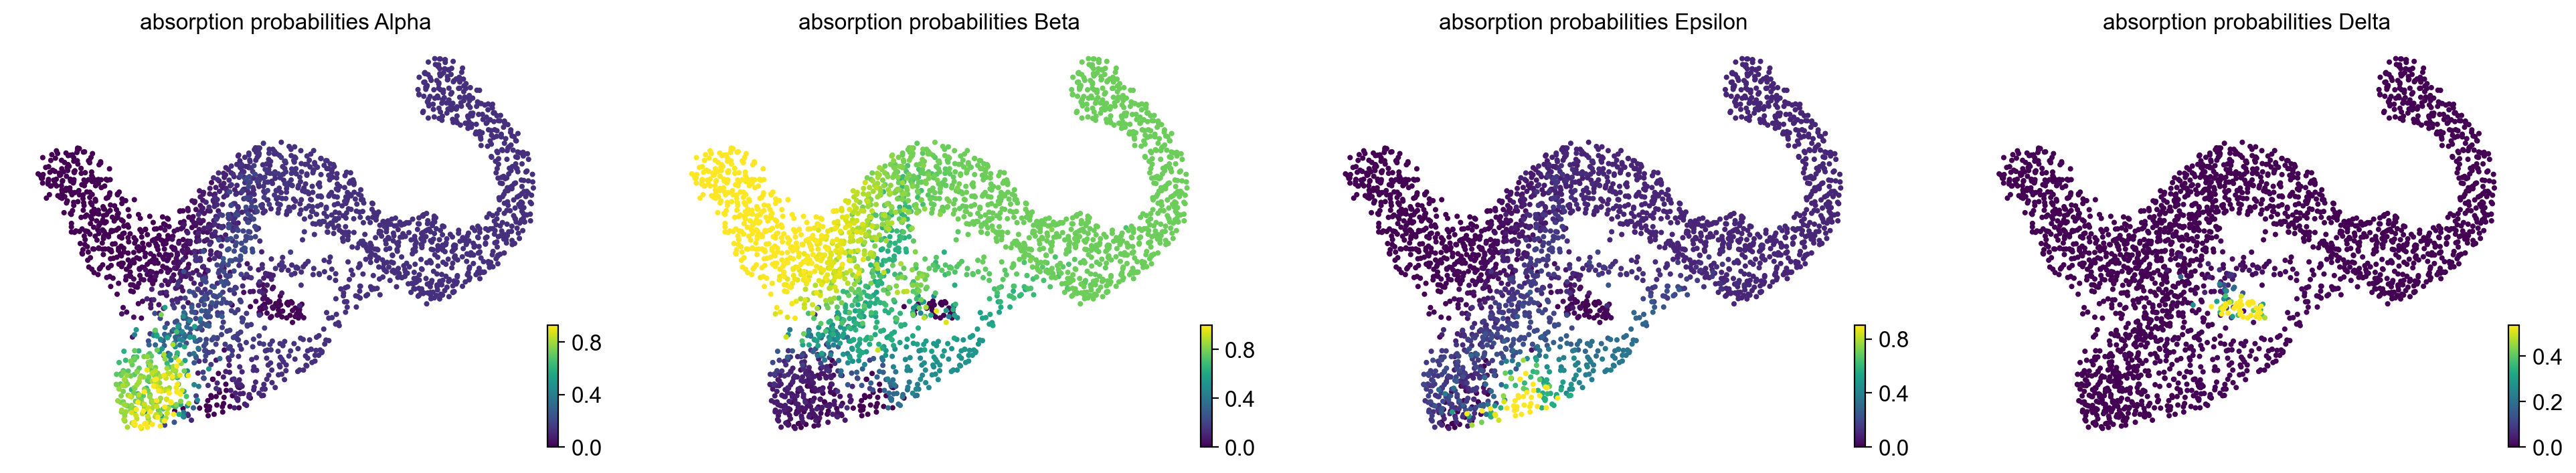

In [8]:
g.compute_absorption_probabilities()
g.plot_absorption_probabilities(same_plot=False)

Most cells appear to be fate-biased towards Beta cells, in agreement with known biology for mouse pancreas development at E15.5 <cite data-cite="bastidas-ponce:19"></cite>. We can visualize these probabilities in compact form by coloring cells according to their most-likely fate, with color intensity reflecting the degree of lineage-bias: 

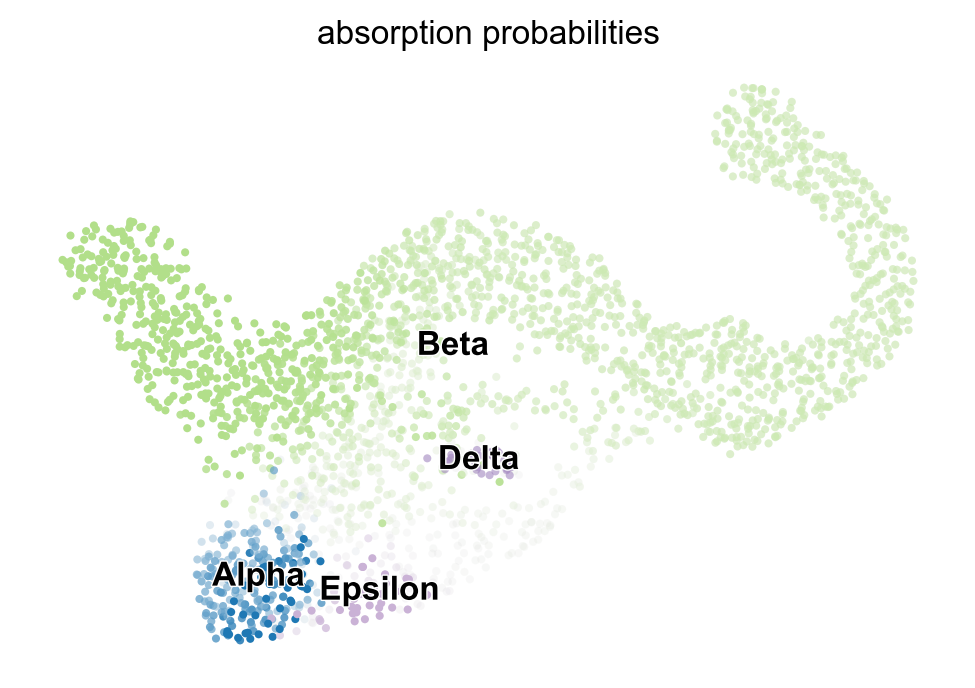

In [9]:
g.plot_absorption_probabilities(same_plot=True)

Another compact way to simultanesosly visualize fate probabilities towards several terminal states is via cirular projections <cite data-cite="velten:17"></cite>. In such a plot, we arrange all terminal states around a unit circle and place cells inside this circle, with a position determined by their fate probabilities. 

Solving TSP for `4` states


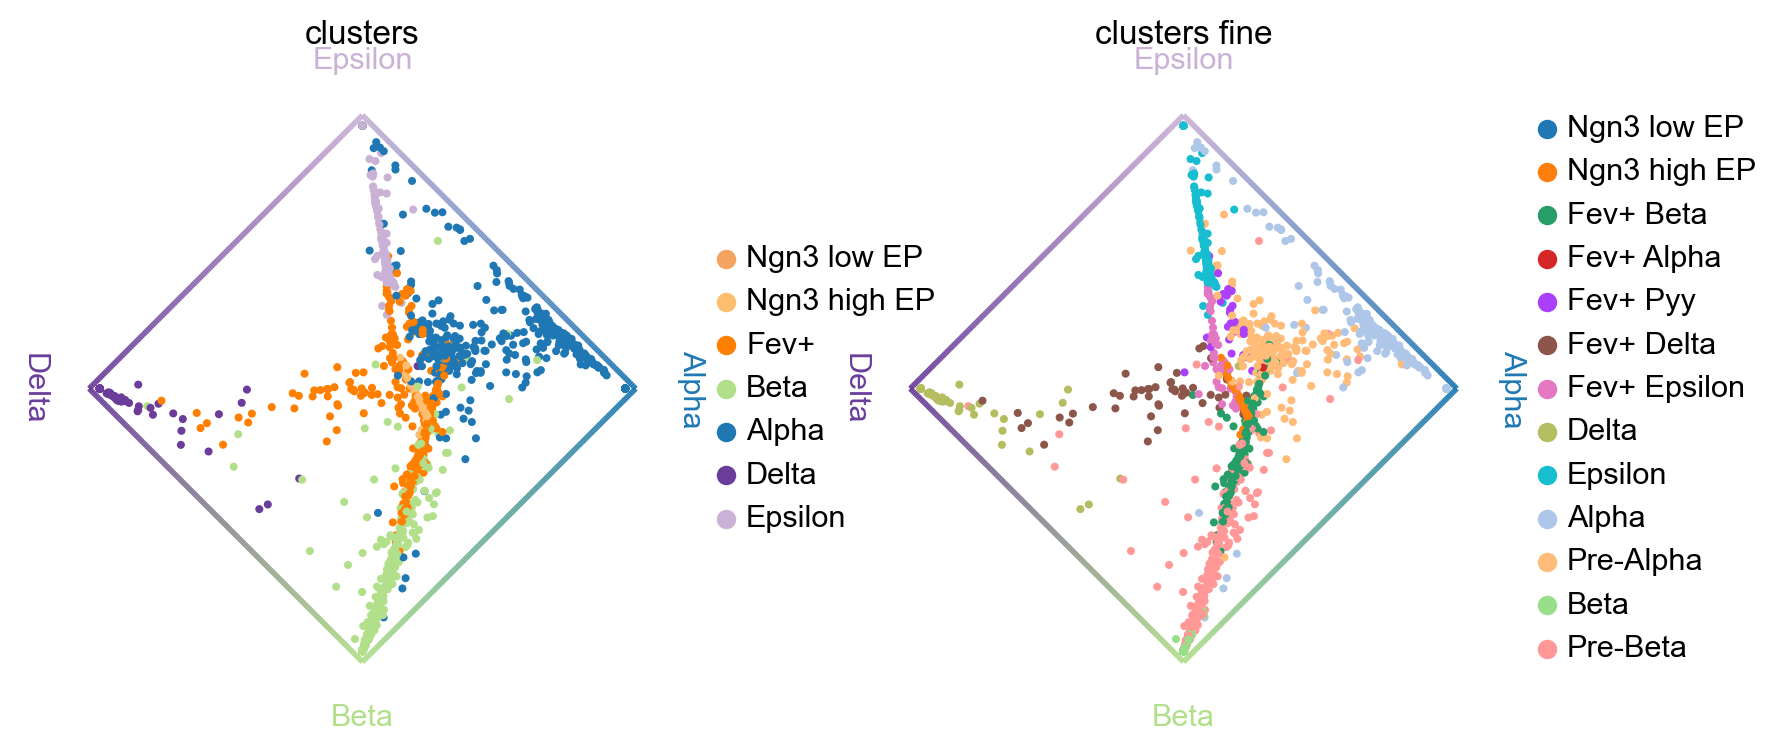

In [10]:
cr.pl.circular_projection(adata, keys=["clusters", "clusters_fine"], legend_loc="right")

**Left plot**: As expected, the algorithm placed more commited cells (Alpha, Beta, etc. ) closer to the edges and less commited cells (Ngn3 low EP, Fev+, etc. ) closer to the middle of the circle.

**Right plot**: Here, we zoom into the Fev+ progenitor population using a subclustering from the original publication <cite data-cite="bastidas-ponce:19"></cite>. As expected, each Fev+ subpopulation is placed closer to its corresponding terminal state. 

## Aggregate fate probabilities

Often, we are interested in aggregated fate probabilities over a group of cells, like a cell- type or state. As an example, let's focus on the Fev+ progenitor populations, and their fate commitment towards Delta cells. Let's start with an overview of these subpopulations. 

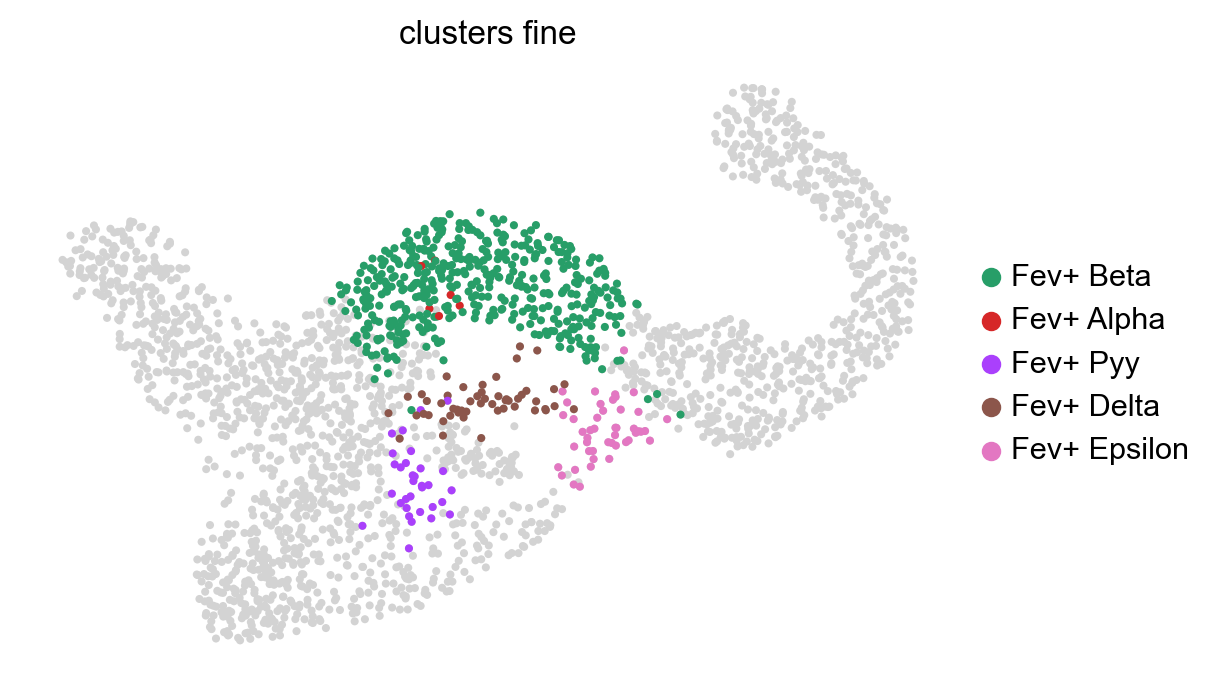

In [11]:
fev_states = ['Fev+ Beta', 'Fev+ Alpha', 'Fev+ Pyy', 'Fev+ Delta', 'Fev+ Epsilon']
scv.pl.scatter(adata, c="clusters_fine", groups=fev_states, legend_loc="right")

Using violin plots, we visualize how fate-commited each of these populations is towards Delta cells. 

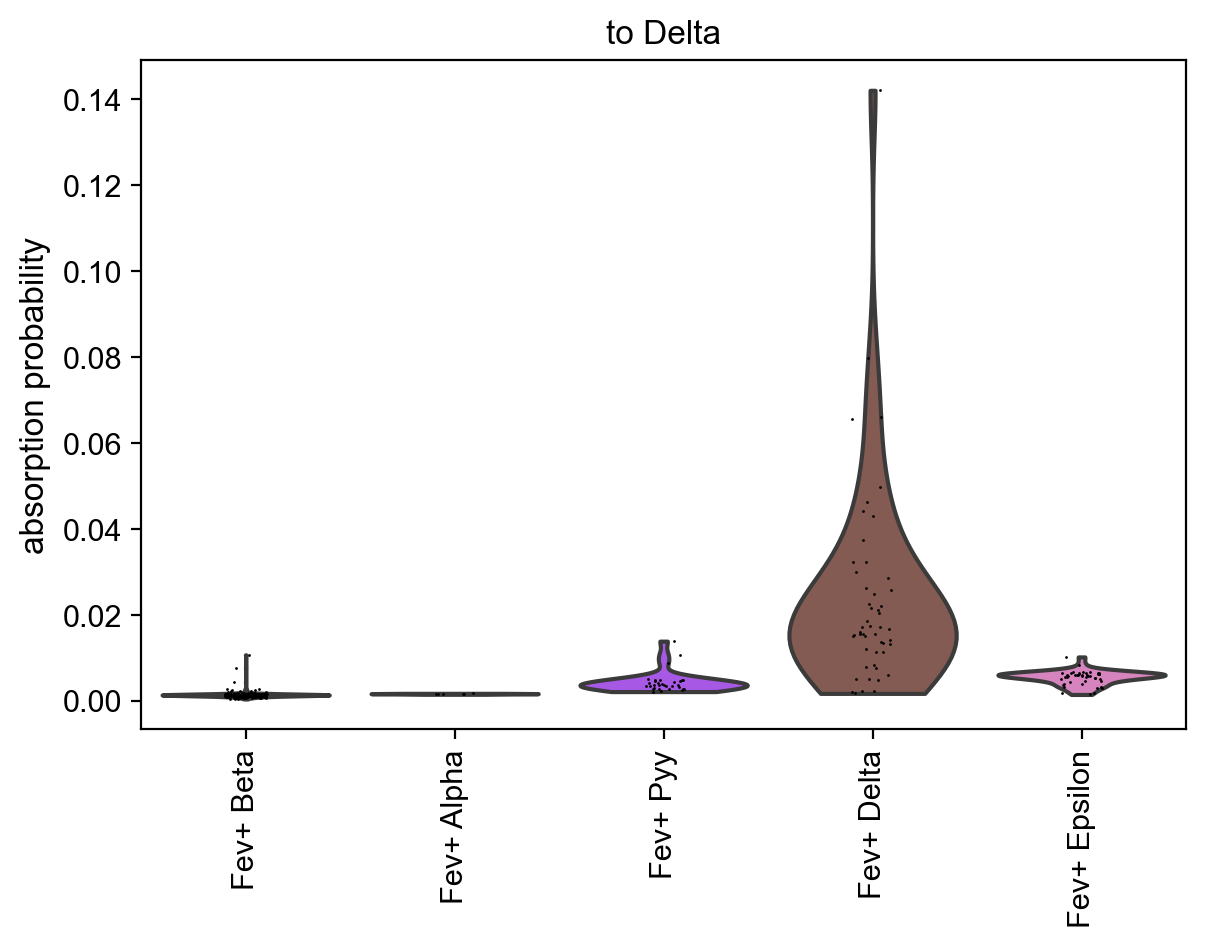

In [12]:
cr.pl.aggregate_absorption_probabilities(
    adata, 
    mode="violin", 
    lineages=["Delta"], 
    cluster_key="clusters_fine", 
    clusters=fev_states
)

As expected, Fev+ Delta cells are most commited towards Delta cells. CellRank supports many more ways to visualize aggregated fate probabilities, for example via heatmaps, bar plots, or paga-pie charts, see the [API](https://cellrank.readthedocs.io/en/latest/api/index.html). 

## Uncover driver genes

We uncover putative driver genes by correlating fate probabilities with gene expression. In other words, if a gene is systematically higher or lower expressed in cells that are more or less likely to differentiate towards a given terminal states, respectively, then we call this gene a putative driver gene. 

As an example, let's focus on Delta cell generation again, and let's restrict the correlation-computation to the relevant clusters. 

In [13]:
driver_clusters = ["Delta", "Fev+", "Ngn3 high EP", "Ngn3 low EP"]

delta_df = g.compute_lineage_drivers(
    lineages=["Delta"], 
    cluster_key="clusters", 
    clusters=driver_clusters
)
delta_df.head(10)

Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


Delta_corr     Delta_pval     Delta_qval  Delta_ci_low  \
index                                                                   
Sst              0.839071   0.000000e+00   0.000000e+00      0.822372   
Iapp             0.737009  6.254049e-258  6.250922e-255      0.711381   
Arg1             0.585740  2.000759e-131  1.333172e-128      0.549197   
Frzb             0.549398  1.462130e-111  7.306992e-109      0.510639   
Pyy              0.530200  3.740700e-102   1.495532e-99      0.490332   
Rbp4             0.509433   1.004597e-92   3.346983e-90      0.468415   
Hhex             0.497606   1.124061e-87   3.209997e-85      0.455955   
1500009L16Rik    0.489818   1.800047e-84   4.497868e-82      0.447760   
Fam159b          0.483945   4.081292e-82   9.065003e-80      0.441584   
Ptprz1           0.461728   1.176800e-73   2.352423e-71      0.418258   

               Delta_ci_high  
index                         
Sst                 0.854326  
Iapp                0.760680  
Arg1                0.620048  
Frzb                0.585929  
Pyy                 0.567854  
Rbp4                0.548260  
Hhex                0.537081  
1500009L16Rik       0.529713  
Fam159b             0.524153  
Ptprz1              0.503087

This computed correlation values, as well as p-values, multiple-testing corrected q-values, and confidence intervals. We can visually explore a few of these genes. 

/Users/marius/Projects/scvelo/scvelo/plotting/utils.py:967: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


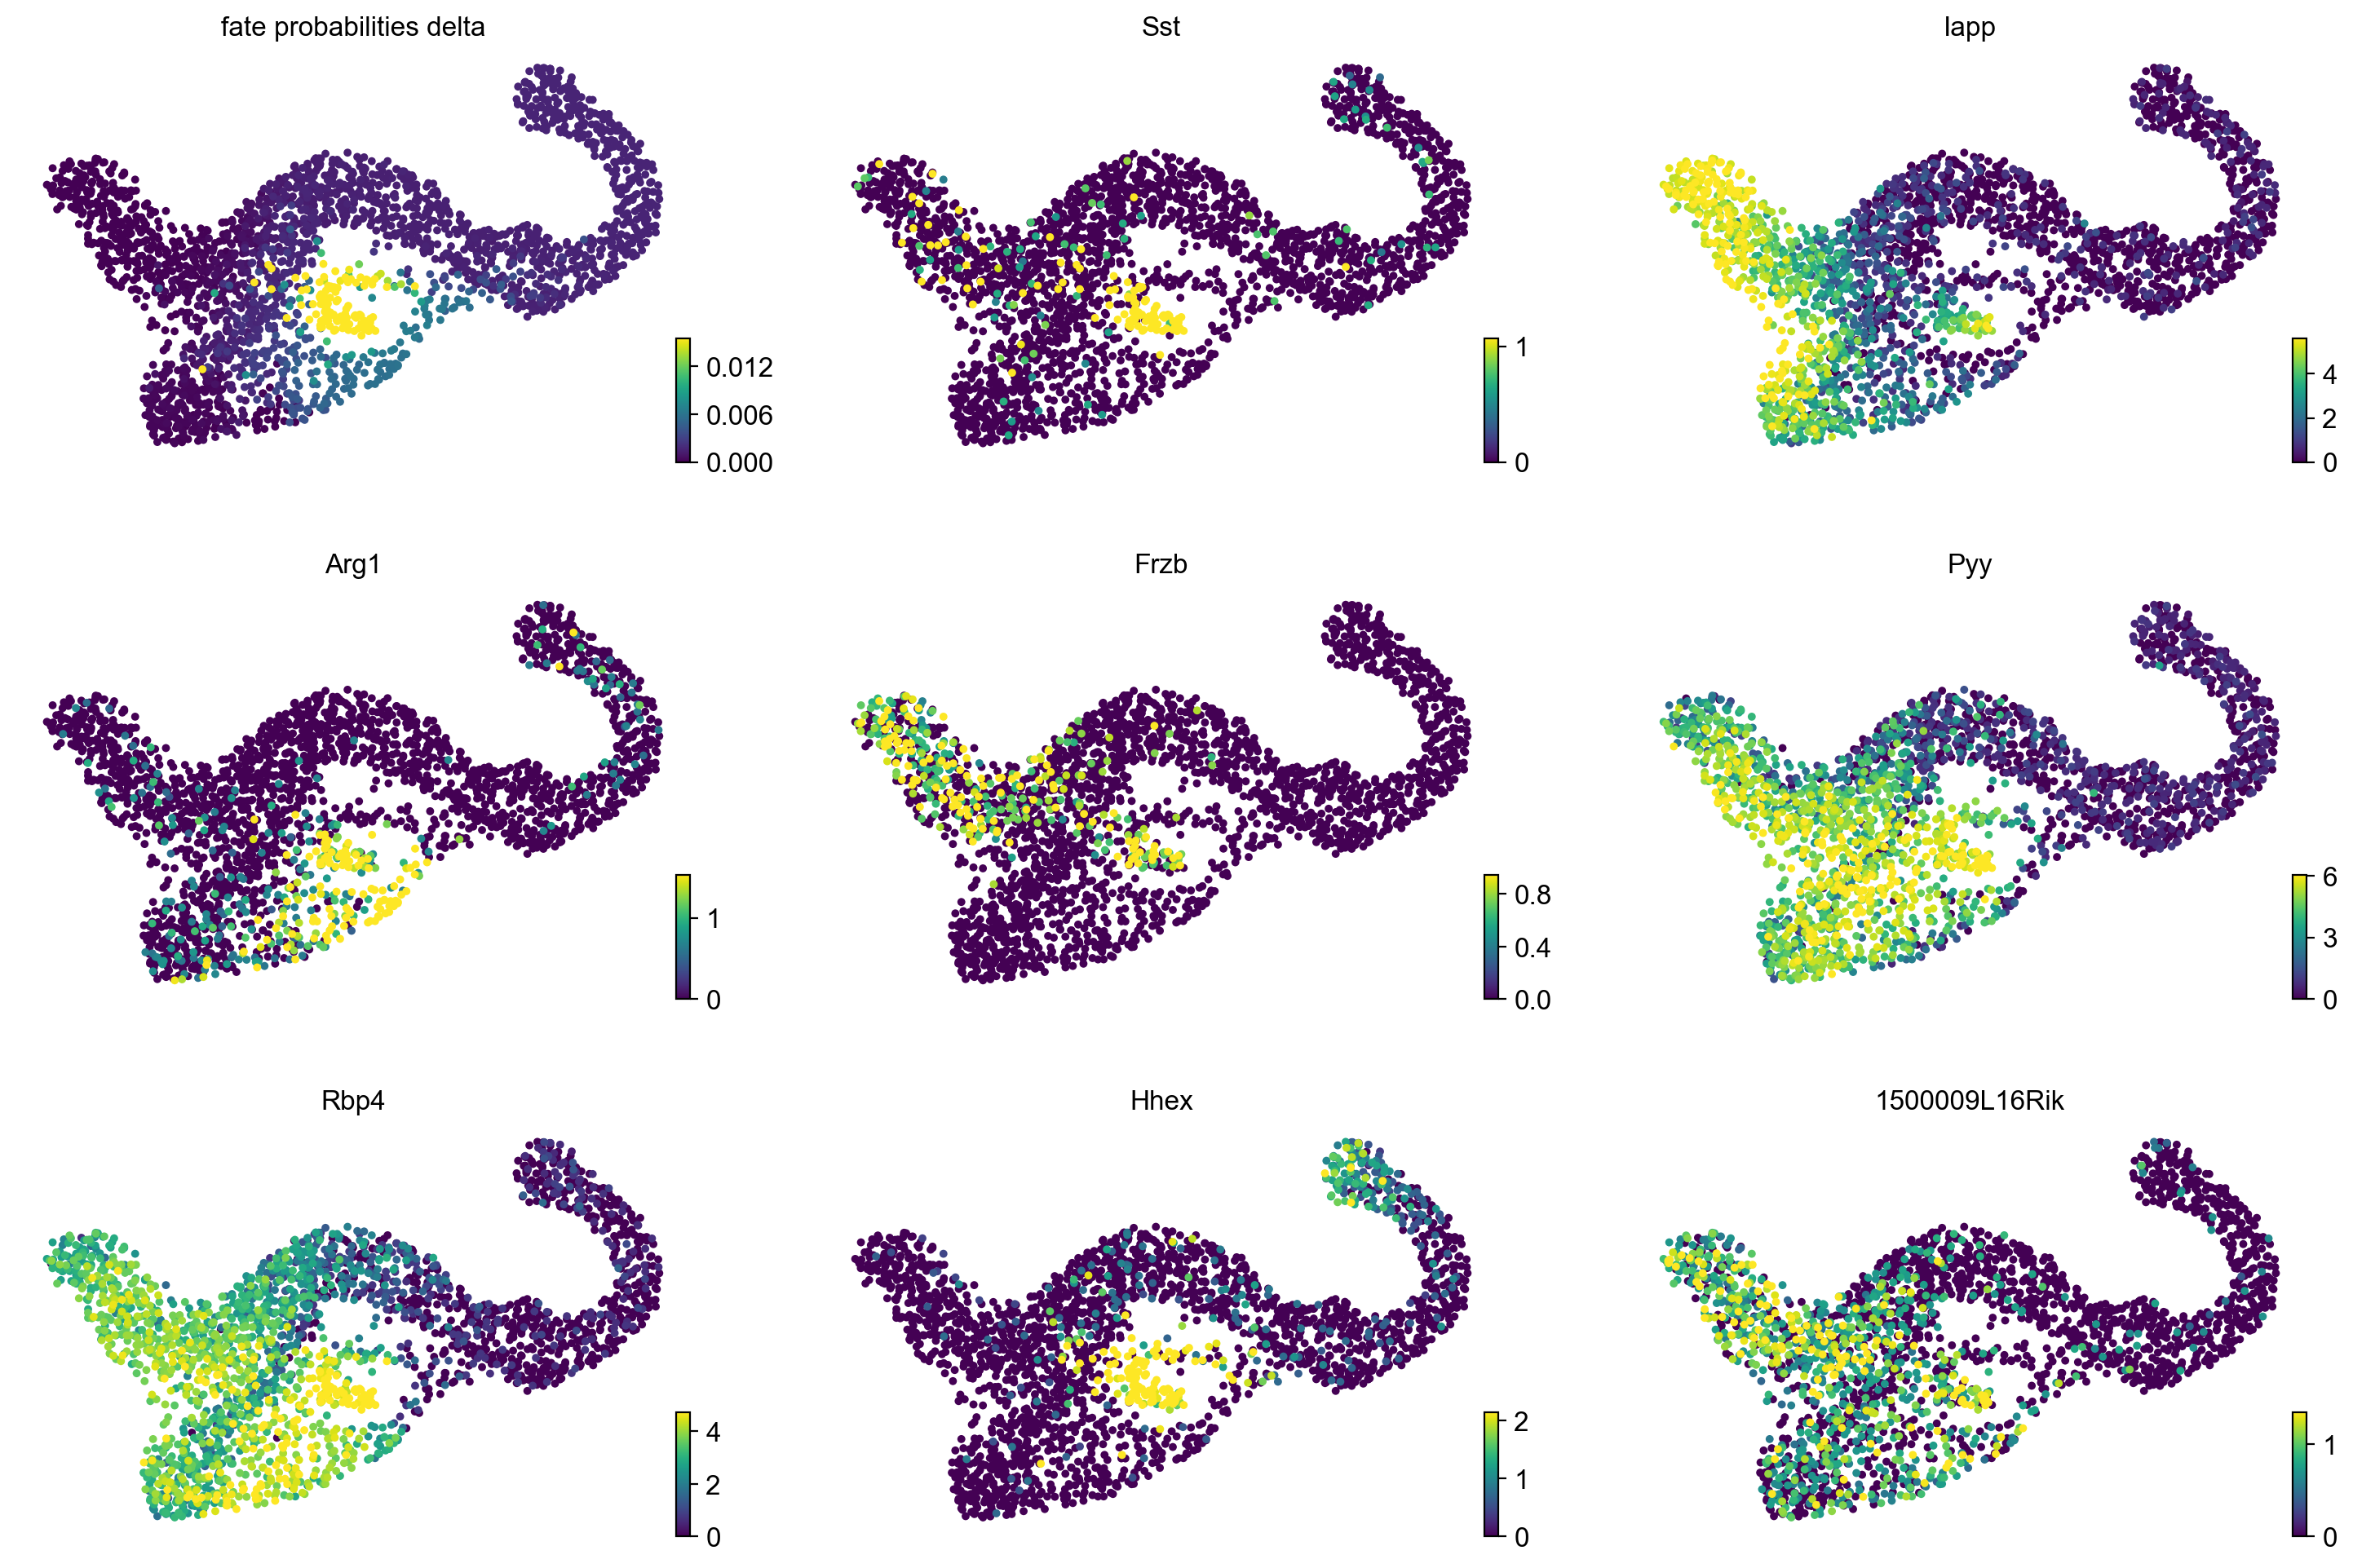

In [14]:
adata.obs["fate_probabilities_delta"] = g.absorption_probabilities["Delta"].X.flatten()

scv.pl.scatter(
    adata, 
    c=["fate_probabilities_delta"] + list(delta_df.index[:8]), 
    color_map="viridis", 
    s=50,
    ncols=3,
    perc=[0, 96],
)

We show fate probabilities towards the Delta population and some of the top-correlating genes. Among them are Somatostatin (*Sst*; the hormone produced by Delta cells) and the homeodomain transcription factor *Hhex* (hematopoietically expressed homeobox), a known driver gene for Delta cell generation <cite data-cite="zhang:14"></cite>. 

Beyond Delta cells, let's compute driver genes for all trajectories, and let's visualize some of the top-correlating genes for the Alpha and Beta lineages. 

Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)
Adjusting text position
    Finish (0:00:01)


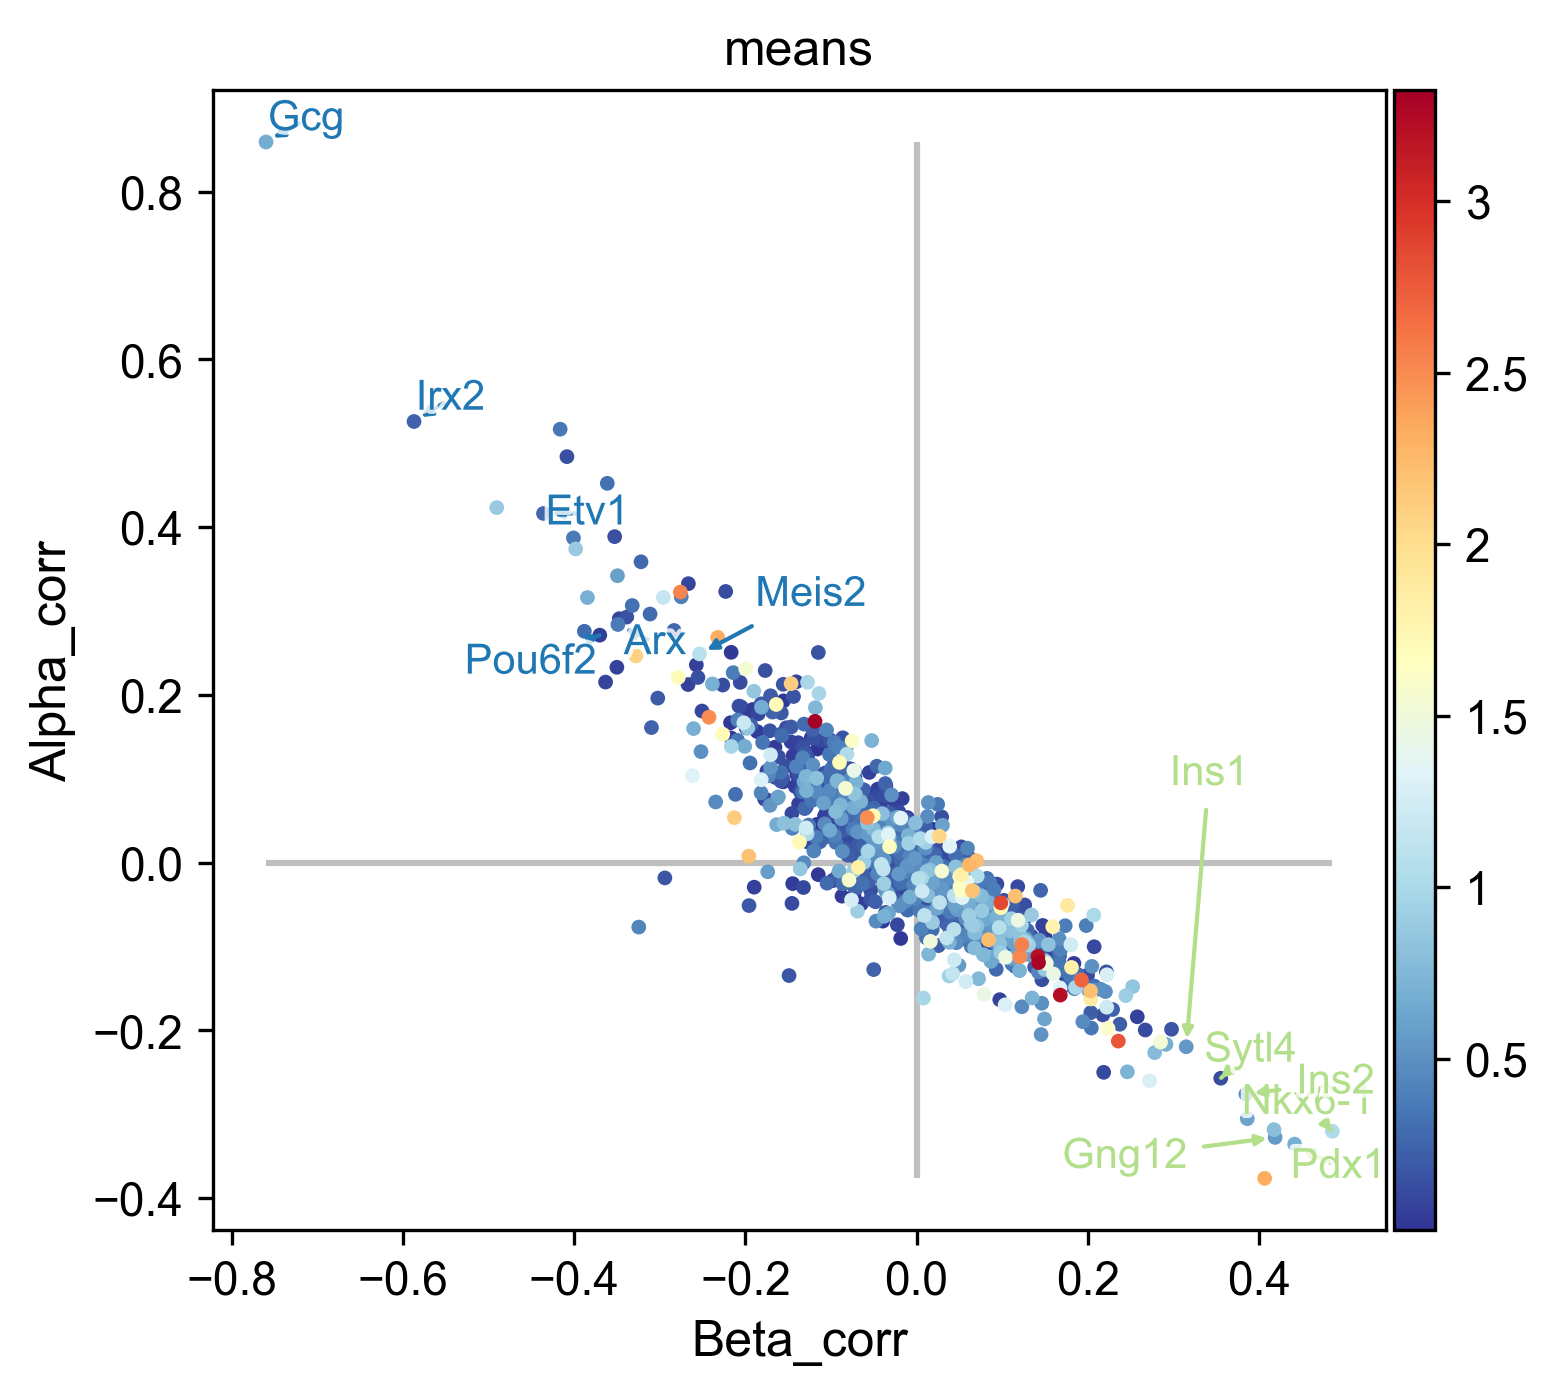

In [15]:
# compute driver genes
driver_df = g.compute_lineage_drivers()

# define set of genes to annotate
alpha_genes = ["Arx", "Gcg", "Irx2", "Etv1", "Pou6f2", "Meis2"]
beta_genes = ["Ins2", "Gng12", "Ins1", "Nkx6-1", "Pdx1", "Sytl4"]

genes_oi = {
    "Alpha": alpha_genes,
    "Beta": beta_genes,
}

# make sure all of these exist in AnnData
assert([gene in adata.var_names for genes in genes_oi.values() for gene in genes]), "Did not find all genes"

# compute mean gene expression across all cells
adata.var["means"] = adata.X.A.mean(axis=0)

# visualize in a scatter plot
g.plot_lineage_drivers_correlation(
    lineage_x="Beta",
    lineage_y="Alpha",
    adjust_text=True,
    gene_sets=genes_oi,
    color="means",
    legend_loc="none",
    figsize=(5, 5),
    dpi=150,
    fontsize=10,
    size=50,
)

In the plot above, each dot represents a gene, colored by mean expression across all cells, with Beta- and Alpha correlations on the x- and y-axis, respectively. As expected, these two are anti-correlated; genes that correlate positively with the Alpha fate correlate negatively with the Beta fate and vice versa. We annotate a few transciption factors (TFs; according to https://www.ncbi.nlm.nih.gov/) with known functions in Beta-or Alpha trajectories, all of which are among the top-30 highest correlated genes: 

| Gene Name | Reference                                     | Trajectory |
|-----------|-----------------------------------------------|------------|
| Arx       | PMID: 32149367, PMID: 23785486, PMID: 24236044 | Alpha     |
| Irx2      | PMID: 26977395                                | Alpha      |
| Etv1      | PMID: 32439909                                | Alpha      |
| Gng12     | PMID: 30254276                                | Beta       |
| Nkx6-1    | PMID: 33121533, PMID: 34349281                | Beta       |
| Pdx1      | PMID: 31401713, PMID: 33526589, PMID: 28580283 | Beta      |
| Sytl4     | PMID: 27032672, PMID: 12058058                | Beta       |

Further, we annotate *Gcg*, the gene encoding the Alpha cell hormone Glucagon, as well as *Ins1* and *Ins2*, the genes encoding the Beta cell hormone Insulin. We also annotate *Pou6f2* and *Meis2*, two TFs which are highly correlated with the Alpha fate probabilities, with no known function in Alpha cell formation or maintenance, to the best of our knowledge. These serve as examples of how fate probabilities can be used to predict putative new driver genes. 

## What's next? 

In this tutorial, you learned how to compute, aggregate and visualize fate probabilities and predict driver genes. For the next steps, we recommend...

- going through the [gene trend plotting tutorial](https://cellrank.readthedocs.io/en/stable/notebooks/tutorials/gene_trends.html) to learn how to visulize gene dynamics in pseudotime.
- taking a look at the [full API](https://cellrank.readthedocs.io/en/stable/api.html) to learn about parameter values you can use to adapt these computations to your data. 
- trying this out on your own data. 

If you encounter any bugs in the code, our if you have suggestions for new features, please open an [issue](https://github.com/theislab/cellrank/issues/new/choose). If you have a general question or something you would like to discuss with us, please post on the [scverse discourse](https://discourse.scverse.org/c/ecosytem/cellrank/40). 

## Package versions

In [16]:
cr.logging.print_versions()

cellrank==1.5.1+gedbc651e scanpy==1.9.3 anndata==0.8.0 numpy==1.24.2 numba==0.57.0rc1 scipy==1.10.1 pandas==1.5.3 pygpcca==1.0.4 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.4 scvelo==0.3.0 pygam==0.8.0 matplotlib==3.7.0 seaborn==0.12.2
